<a href="https://colab.research.google.com/github/Srivishnu27feb/Sentiment-Analysis---BiLSTM/blob/master/Sentiment_Analysis_Bi_LSTM_Pytorch_(Glove_Embedding).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchtext import data
from torchtext import datasets

We'll be using packed padded sequences, which will make our RNN only process the non-padded elements of our sequence, and for any padded element the output will be a zero tensor

In [ ]:
SEED = 1234

torch.manual_seed(SEED)
#results need not be reproducible between CPU and GPU executions for a raandom seed so deterministic = True
torch.backends.cudnn.deterministic = True

#TEXT Defines a datatype together with instructions for converting to Tensor
#include_lengths will tell RNN the length of the sequence
TEXT = data.Field(tokenize='spacy',include_lengths=True)

#LABEL designed to hold labels for a classification task
#TorchText set the tensors to longtext so should be converted to 32 bit float for Criterion to consume
LABEL = data.LabelField(dtype = torch.float)


In [ ]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

import random
#By default will take 70:30 split
train_data,valid_data = train_data.split(random_state = random.seed(SEED))

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:07<00:00, 11.2MB/s]


In [ ]:
print(vars(train_data.examples[0]))

{'text': ['Other', 'than', 'some', 'neat', 'special', 'effects', ',', 'this', 'movie', 'has', 'nothing', 'to', 'offer', '.', 'They', 'threw', 'in', 'some', 'gore', 'and', 'some', 'nudity', 'to', 'try', 'and', 'make', 'it', 'interesting', ',', 'but', 'with', 'no', 'success', '.', 'Kevin', 'Bacon', "'s", 'acting', 'was', 'pretty', 'good', ',', 'but', 'he', 'could', "n't", 'salvage', 'the', 'movies', 'lack', 'of', 'plot', '.'], 'label': 'neg'}


Here, we'll be using the "glove.6B.100d" vectors". glove is the algorithm used to calculate the vectors instead of starting from the scratch. 6B- trained on 6 billion tokens and 100d is 100 dimensional vectors.

unk_init (callback) – by default, initialize out-of-vocabulary word vectors to zero vectors; can be any function that takes in a Tensor and returns a Tensor of the same size. Default: torch.Tensor.zero_
But not in your pre-trained embeddings to zero. We initialize them randomly by setting unk_init to torch.Tensor.normal_so this will now initialize those words via a Normal distribution.

Ref: https://torchtext.readthedocs.io/en/latest/

In [ ]:
Max_vocab_size = 25000

TEXT.build_vocab(train_data,max_size =Max_vocab_size,
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:30, 2.21MB/s]                           
100%|█████████▉| 398780/400000 [00:16<00:00, 24835.10it/s]

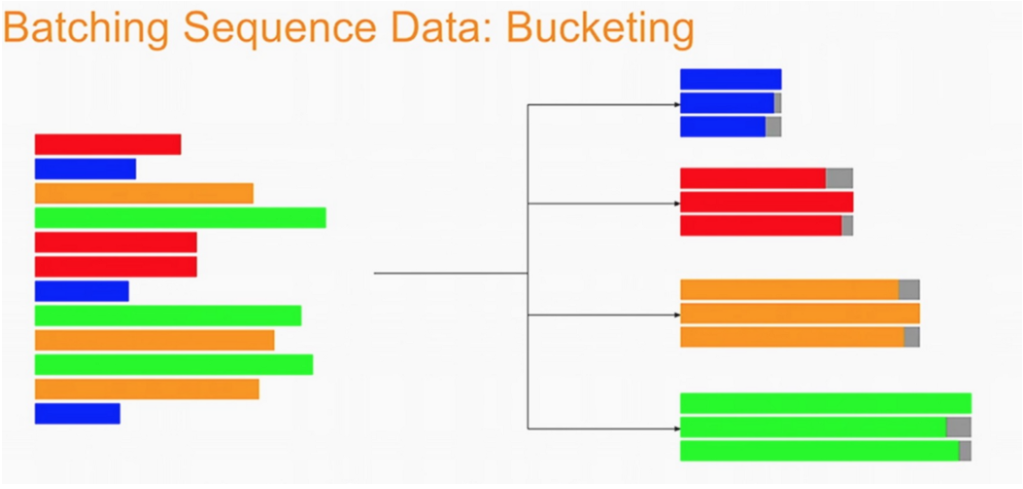


In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# BucketIterator will help in bucketting the input with similar sequence length together therby computation will be fast as well as the gradient update will be accurate
train_iterator,test_iterator,valid_iterator = data.BucketIterator.splits(
                                                (train_data,test_data,valid_data),
                                                batch_size = BATCH_SIZE,
                                                sort_within_batch = True,
                                                device = device)

# **Model Building**
The next stage is building the model:

The process is as follows:

**Convert One hot encoding (sparse Matrix) --> Dense Martix (Embedding) --> RNN/ LSTM/ GRU as input.**

**Super** keyword in RNN class will allows us to avoid using the base class name explicitly and also in working with Multiple Inheritance

**Constructors/init** : All the 3 layers (embedding layer, our RNN, and a linear layer) are defined here. This will be invoked first when the object is created for the RNN class. All layers have their parameters initialized to random values, unless explicitly specified.

**Embedding Layer:** The embedding layer is used to transform our sparse one-hot vector into a dense embedding vector. This embedding layer is simply a single fully connected layer. It reduces the dimensionality of the input to the RNN, there is the theory that words which have similar impact on the sentiment of the review are mapped close together in this dense vector space.

**The BI-LSTM layer:** It takes in our dense vector and the previous hidden state ht−1 , which it uses to calculate the next hidden state, ht .
LSTM differs from RNN as follows: It returns the output and a tuple of the final hidden state and the final cell state, whereas the standard RNN only returned the output and final hidden state.The final hidden state of our LSTM has both a forward and a backward component, which will be concatenated togetherto the next level.

**Why is an LSTM better than a standard RNN?** Standard RNNs suffer from the vanishing gradient problem. LSTMs overcome this by having an extra recurrent state called a cell,  c  - which can be thought of as the "memory" of the LSTM - and the use use multiple gates which control the flow of information into and out of the memory

Finally, the linear layer takes the final hidden state (Forward & Backward (hidden*2)) and feeds it through a fully connected layer, f(hT) , transforming it to the correct output dimension.

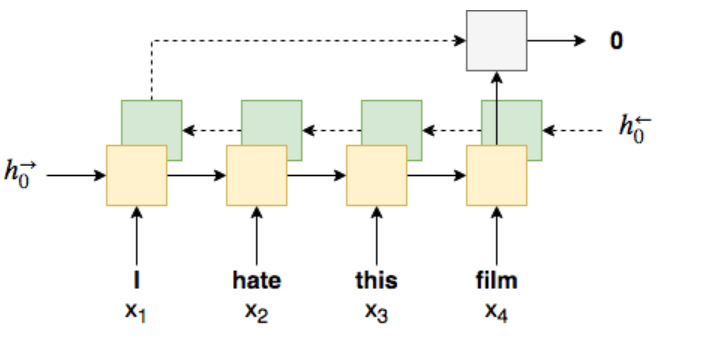

**Forward Method** is called when the input examples are fed to the model

In [ ]:
import torch.nn as nn

class LSTM(nn.Module):

  ##Initialization happens below which is the constructor
    def __init__(self,vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                bidirectional, dropout, pad_idx):
        super().__init__()

        #we are not going to learn the embedding for the <pad> token. 
        #This is because we want to explitictly tell our model that padding tokens are irrelevant to determining the sentiment of a sentence.
        #so we will provide the pad_idx

        #Embedding will take input dim(vocab_size) & embedding dimension
        self.embedding = nn.Embedding(vocab_size,embedding_dim,padding_idx = pad_idx)

        #Define the no of layers, dropout & type of direction (bi- Forward & backword direction)
        #LSTM/RNN will take embedding dimension n previous hidden state
        self.rnn = nn.LSTM(embedding_dim,hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout
                            )
        #Fully connected layer is a linear layer which outputs the final prediction
        # It takens the two directional Hidden state(Forward & Backward) i.e. hidden*2 
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
          
        #Dropout is used as a regularization technique (to avoid overfitting)
        # It just operates as a switch (to on & off certain nodes)
        self.dropout = nn.Dropout(dropout)

    # text_length to tell the RNN the max length of each sequence
    def forward(self, text, text_lengths):
    #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))

        #embedded = [sent len, batch size, emb dim]

        #pack sequence
        #Before we pass our embeddings to the RNN, we need to pack them nn.utils.rnn.pack_padded_sequence
        #as LSTM will process only non-padded words of our sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)

        #The RNN will then return packed_output (a packed sequence) as well as the hidden and cell states 
        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        #unpack sequence
        #Transform packed_output from a packed sequence to a tensor
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors

        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout

        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
        
        return self.fc(hidden)


In [ ]:
INPUT_DIM = len(TEXT.vocab)
#EMBEDDING_DIM must be equal to that of the pre-trained GloVe vectors
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTM(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [ ]:
def total_trainable_params(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Trainable parameters: {total_trainable_params(model)}")

Total Trainable parameters: 4810857


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
pretrained_embeddings.shape

torch.Size([25002, 100])

In [ ]:
#We then replace the initial weights of the embedding layer with the pre-trained embeddings
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.8591, -0.7120,  0.0041,  ..., -1.1054, -0.8005,  0.2965],
        [-1.6772,  0.4427, -0.1157,  ..., -1.0376,  1.1156, -1.8099],
        [ 2.0426, -1.7188,  0.2626,  ...,  0.6916, -0.7286, -1.3932]])

In [ ]:
#As our <unk> and <pad> token aren't in the pre-trained vocabulary they have been initialized using unk_init (an  N(0,1)  distribution) 
#when building our vocab. It is preferable to initialize them both to all zeros to explicitly as they are irrelevant for determining sentiment.
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

#setting <unk> and <pad> row in the embedding weights matrix to zeros
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.8591, -0.7120,  0.0041,  ..., -1.1054, -0.8005,  0.2965],
        [-1.6772,  0.4427, -0.1157,  ..., -1.0376,  1.1156, -1.8099],
        [ 2.0426, -1.7188,  0.2626,  ...,  0.6916, -0.7286, -1.3932]])

### Model Training
SGD updates all parameters with the same learning rate and choosing this learning rate can be tricky. Adam adapts the learning rate for each parameter, giving parameters that are updated more frequently lower learning rates and parameters that are updated infrequently higher learning rates


In [ ]:
import torch.optim as optim
#Optimizer used in adam and the parameters should be optimized
optim = optim.Adam(model.parameters())

The Loss is defined using Criterion. Here we used logit with Binary Cross Entropy. Logit is to make sure the output predict is within the range 0-1

In [ ]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


Function to calculate Model accuracy

In [ ]:
def accuracy_binary(preds, y):
    correct_pred = (torch.round(torch.sigmoid(preds)) == y).float()
    return (correct_pred.sum()/len(correct_pred))
    

In [ ]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in iterator:

    #default assign optimizer with zero gradient and allow to change during training     
        optimizer.zero_grad()

        #batch.text will have both text sequence and length as we defined it earlier through "include_lengths"
        text, text_lengths = batch.text

        #Squeeze it to remove one dimension for criterion to process
        predictions = model(text, text_lengths).squeeze(1)

        #Calculate Loss 
        loss = criterion(predictions, batch.label)

        #Calculate Accuracy
        acc = accuracy_binary(predictions, batch.label)

        #Backward Propagation
        loss.backward()

        #Update optimizer gradients
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    #retuen avg loss & avg acc
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
## This is the test phase where no learning is required
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    ##During evaluation dropout should be turned off so we ensure that by calling model.eval()
    model.eval()

    with torch.no_grad(): 
        for batch in iterator:

            #Gradients shouldnt be updated during eval
            #optimizer.zero_grad()

            #batch.text will have both text sequence and length as we defined it earlier through "include_lengths"
            text, text_lengths = batch.text

            #Squeeze it to remove one dimension for criterion to process
            predictions = model(text, text_lengths).squeeze(1)

            #Calculate Loss 
            loss = criterion(predictions, batch.label)

            #Calculate Accuracy
            acc = accuracy_binary(predictions, batch.label)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
      #retuen avg loss & avg acc
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

**torch.save:** Saves a serialized object to disk. This function uses Python’s pickle utility for serialization. Models, tensors, and dictionaries of all kinds of objects can be saved using this function.


**torch.load:** Uses pickle’s unpickling facilities to deserialize pickled object files to memory. This function also facilitates the device to load the data into (see Saving & Loading Model Across Devices).


**torch.nn.Module.load_state_dict:** Loads a model’s parameter dictionary using a deserialized state_dict

Ref: https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [ ]:
Epochs = 6

##Default list to store the min loss
best_valid_loss = float('inf')

for epoch in range(Epochs):

    start_time = time.time()
    
    #train model
    train_loss, train_acc = train(model, train_iterator, optim, criterion)
    #Evaluate model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

100%|█████████▉| 398780/400000 [00:30<00:00, 24835.10it/s]

Epoch: 01 | Epoch Time: 0m 38s
	Train Loss: 0.618 | Train Acc: 65.27%
	 Val. Loss: 0.541 |  Val. Acc: 72.76%
Epoch: 02 | Epoch Time: 0m 39s
	Train Loss: 0.510 | Train Acc: 75.13%
	 Val. Loss: 0.461 |  Val. Acc: 78.82%
Epoch: 03 | Epoch Time: 0m 41s
	Train Loss: 0.394 | Train Acc: 82.93%
	 Val. Loss: 0.344 |  Val. Acc: 85.51%
Epoch: 04 | Epoch Time: 0m 40s
	Train Loss: 0.296 | Train Acc: 87.98%
	 Val. Loss: 0.321 |  Val. Acc: 86.92%
Epoch: 05 | Epoch Time: 0m 40s
	Train Loss: 0.252 | Train Acc: 90.11%
	 Val. Loss: 0.303 |  Val. Acc: 87.58%
Epoch: 06 | Epoch Time: 0m 40s
	Train Loss: 0.215 | Train Acc: 91.65%
	 Val. Loss: 0.320 |  Val. Acc: 88.33%


# Testing the new inputs:

Steps:
  1. Call Eval function
  2. Tokenize the words from sentence
  3. word to index for passing the input value
  4. Unsqueeze rowwise :
  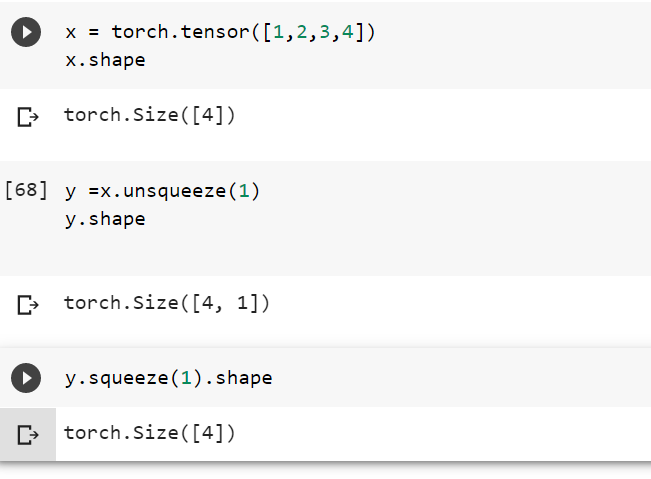
  
  5. Make both Length & index of sentence as long tensor
  6. Pass the text & length of text to the model 
  7. Predict the sentence 


In [ ]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [ ]:
predict_sentiment(model, "This film is terrible")

0.005331734661012888

In [ ]:
predict_sentiment(model, "Film was good")

0.9321081638336182